# Manipulating Hierarchies in Atoti

In this notebook, we'll show you a few tips for manipulating hierarchies in Atoti to serve your analytical needs. In particular, we'll discuss some of the basic properties of hierarchies, along with some of the nuances for working with the following types of hierarchies:

* Multi-level hierarchies
* Slicing hierarchies
* Virtual hierarchies

💡 **Note:** Still getting familiar with hierarchies in Atoti? Make sure to visit the [Hierarchy Fundamentals in Atoti](../main.ipynb) notebook for a basic introduction.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=hierarchy-manipulations" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

## Set up the Atoti data model and cube

First things first, let's set up our data model and cube in Atoti. As we continue our exploration of hierarchies in Atoti, we'll utilize the same cube that we set up in the previous notebook: [Hierarchy Fundamentals in Atoti](01-hierarchy-fundamentals.ipynb).

To do this, we've created a [setup.py](utils/setup.py) script that automates some of the prerequisite steps. 

In [1]:
import atoti as tt
from utils import setup

cube, session = setup.main()

## Analyze the Atoti cube

Now that the data has been loaded into the cube, let's take a look at the data model of the cube to confirm we have things set up properly. And as always, we can alias the hierarchies, levels, and measures as new variables for enhanced readability when manipulating these components of the cube.

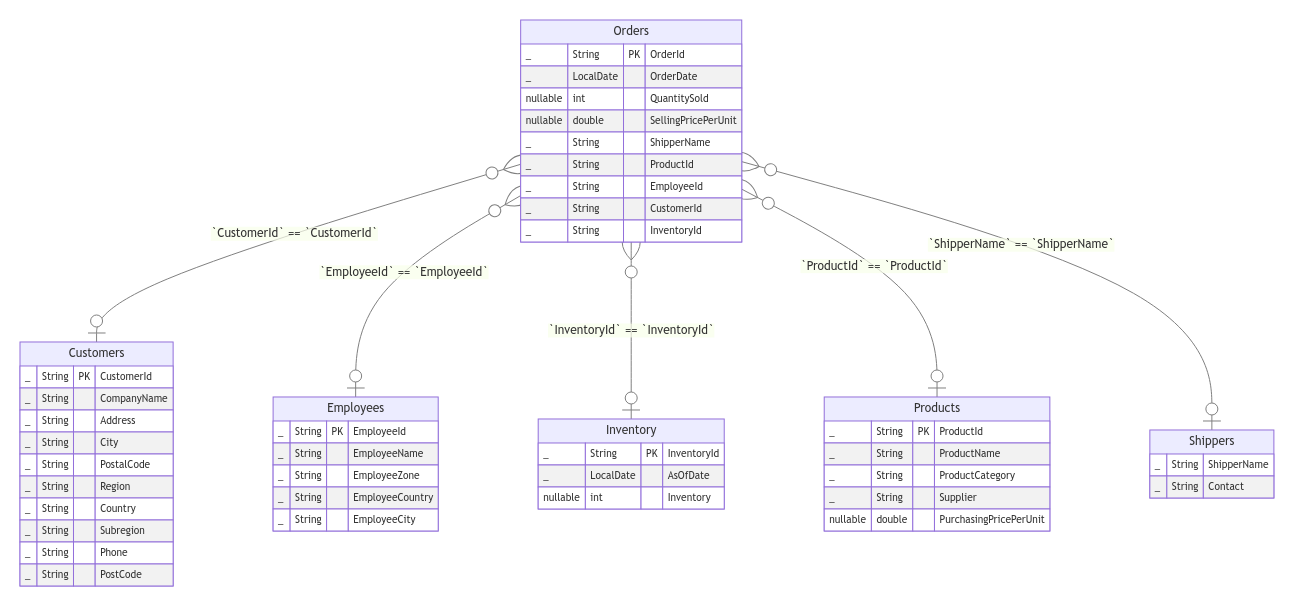

In [2]:
# View the schema of the data model
session.tables.schema

In [3]:
# Set aliases for hierarchies, levels, and measures
h, l, m = cube.hierarchies, cube.levels, cube.measures

## Viewing hierarchies

Great, looks like we're set up. Let's now take a look at the list of our hierarchies to see which ones we want to manipulate.

In [4]:
h

{('Orders', 'ShipperName'): <atoti.hierarchy.Hierarchy object at 0x11f859330>, ('Orders', 'OrderId'): <atoti.hierarchy.Hierarchy object at 0x11f858a00>, ('Orders', 'InventoryId'): <atoti.hierarchy.Hierarchy object at 0x11f84d450>, ('Orders', 'CustomerId'): <atoti.hierarchy.Hierarchy object at 0x11f84d870>, ('Orders', 'ProductId'): <atoti.hierarchy.Hierarchy object at 0x11f84df00>, ('Orders', 'OrderDate'): <atoti.hierarchy.Hierarchy object at 0x11f84dc60>, ('Orders', 'EmployeeId'): <atoti.hierarchy.Hierarchy object at 0x11f84faf0>, ('Products', 'ProductName'): <atoti.hierarchy.Hierarchy object at 0x11f84ece0>, ('Products', 'Supplier'): <atoti.hierarchy.Hierarchy object at 0x11f84de10>, ('Products', 'ProductCategory'): <atoti.hierarchy.Hierarchy object at 0x11f84f610>, ('Customers', 'PostalCode'): <atoti.hierarchy.Hierarchy object at 0x11f84ded0>, ('Customers', 'PostCode'): <atoti.hierarchy.Hierarchy object at 0x11f84ee00>, ('Customers', 'Phone'): <atoti.hierarchy.Hierarchy object at 0x11f84d750>, ('Customers', 'Address'): <atoti.hierarchy.Hierarchy object at 0x11f84d840>, ('Customers', 'CompanyName'): <atoti.hierarchy.Hierarchy object at 0x11f84f400>, ('Customers', 'Subregion'): <atoti.hierarchy.Hierarchy object at 0x11f84e170>, ('Customers', 'Country'): <atoti.hierarchy.Hierarchy object at 0x11f84f280>, ('Customers', 'Region'): <atoti.hierarchy.Hierarchy object at 0x11f84e7d0>, ('Customers', 'City'): <atoti.hierarchy.Hierarchy object at 0x11f84d600>, ('Shippers', 'Contact'): <atoti.hierarchy.Hierarchy object at 0x11f84e1d0>, ('Employees', 'EmployeeName'): <atoti.hierarchy.Hierarchy object at 0x11f84df60>, ('Employees', 'EmployeeCountry'): <atoti.hierarchy.Hierarchy object at 0x11f84d6c0>, ('Employees', 'EmployeeCity'): <atoti.hierarchy.Hierarchy object at 0x11f84da80>, ('Employees', 'EmployeeZone'): <atoti.hierarchy.Hierarchy object at 0x11f84f670>, ('Inventory', 'AsOfDate'): <atoti.hierarchy.Hierarchy object at 0x11f84e980>}

## Basic Hierarchy Properties

Each hierarchy is an object of the [atoti.Hierarchy](https://docs.atoti.io/latest/api/atoti.Hierarchy.html#atoti.Hierarchy) class. This means that we are able to interact with and manipulate hierarchies using their associated class properties and functions. Hierarchy properties gives us more insight into the specifics of each hierarchy in the cube, and ultimately helps us make better decisions when it comes to data analysis.

A few basic properties are as follows:

* [dimension](#Hierarchy.dimension)
* [dimension_default](#Hierarchy.dimension_default)
* [name](#Hierarchy.name)
* [visible](#Hierarchy.visible)

#### `Hierarchy.dimension`

The [dimension](https://docs.atoti.io/latest/api/atoti.Hierarchy.dimension.html#atoti.Hierarchy.dimension) property of a hierarchy returns the name of its parent dimension. This is helpful for when we want to know which dimension a particular hierarchy falls within. For example, we can call the `dimension` property of the `Address` hierarchy to determine that its parent dimension is `Customers`.

> 💡 **Note:** Remember that when we loaded our tables into our cube, the tables effectively became our dimensions and the non-numeric columns became our hierarchies. Therefore, the `Address` column of our `Customer` table became the `Address` hierarchy under the `Customer` dimension of our cube, respectively. See the previous cube data model/schema visualization for reference.  

In [5]:
h["Address"].dimension

'Customers'

#### `Hierarchy.dimension_default`

Every dimension in the cube has a designated default hierarchy. This is helpful as some UIs support clicking on a dimension (or dragging and dropping it) as a shortcut to add its default hierarchy to a widget.

Calling the [dimension_default](https://docs.atoti.io/latest/api/atoti.Hierarchy.dimension_default.html#atoti.Hierarchy.dimension_default) property of a hierarchy returns `True` or `False` for whether or not the specified hierarchy is the default hierarchy of its parent dimension. For example, if we call the `dimention_default` property of our `Address` hierarchy, we see the following:

In [6]:
h["Address"].dimension_default

False

In this case, the `Address` hierarchy of the `Customers` dimension is **not** the default hierarchy for the `Customers` dimension. So which hierarchy **is** the default hierarchy for the `Customers` dimension?

We can create a simple `for` loop to test this. 

> 💡 **Note:** The `Orders` and `Customers` tables are joined by the common key: `CustomerId`. However, from an Atoti data model perspective, `CustomerId` is a hierarchy present under the base table or `Orders` dimension, and is no longer present as a (redundant) hierarchy under the `Customers` dimension. Therefore, when checking the `Customers` dimension for its default hierarchy, we must filter out the `CustomerId` out from the search criteria — otherwise we get a missing `KeyError`.

In [7]:
def check_default_hierarchy(hierachies, table):
    """Checks for the default hierarchy for an Atoti Table object."""
    dimension = table.name
    for hierarchy in list(table):
        if hierarchy != "CustomerId":
            print(
                f"h['{dimension}', '{hierarchy}'].dimension_default == {h[dimension, hierarchy].dimension_default}"
            )


customers = session.tables["Customers"]
check_default_hierarchy(h, customers)

h['Customers', 'CompanyName'].dimension_default == False
h['Customers', 'Address'].dimension_default == False
h['Customers', 'City'].dimension_default == False
h['Customers', 'PostalCode'].dimension_default == True
h['Customers', 'Region'].dimension_default == False
h['Customers', 'Country'].dimension_default == False
h['Customers', 'Subregion'].dimension_default == False
h['Customers', 'Phone'].dimension_default == False
h['Customers', 'PostCode'].dimension_default == False


We can see that the default hierarchy for the `Customers` dimension is actually `PostalCode`.

A new default hierarchy for a dimension can be assigned as well. For example, we can set our `Address` hierarchy as the default hierarchy for the `Customers` dimension like so:

In [8]:
h["Address"].dimension_default = True

Then, if we re-use the `check_default_hierarchy` function that we defined previously, we can see that the default hierarchy for the `Customers` dimension has indeed been updated.

In [9]:
check_default_hierarchy(h, customers)

h['Customers', 'CompanyName'].dimension_default == False
h['Customers', 'Address'].dimension_default == True
h['Customers', 'City'].dimension_default == False
h['Customers', 'PostalCode'].dimension_default == False
h['Customers', 'Region'].dimension_default == False
h['Customers', 'Country'].dimension_default == False
h['Customers', 'Subregion'].dimension_default == False
h['Customers', 'Phone'].dimension_default == False
h['Customers', 'PostCode'].dimension_default == False


#### `Hierarchy.name`

The [name](https://docs.atoti.io/latest/api/atoti.Hierarchy.name.html#atoti.Hierarchy.name) property of a hierarchy will output the name of the hierarchy like so:

In [10]:
h["Address"].name

'Address'

Though this is a bit redundant when we already know the name of the hierarchy. Therefore, using the `name` property may be more helpful when trying to execute a `for` loop to iterate over all hierarchies in an Atoti data model, where we may want the colloquial hierarchy name rather than the fully qualified one (with both the dimension and hierarchy listed).

In [11]:
for key in h.keys():
    print(key)

('Orders', 'ShipperName')
('Orders', 'OrderId')
('Orders', 'InventoryId')
('Orders', 'CustomerId')
('Orders', 'ProductId')
('Orders', 'OrderDate')
('Orders', 'EmployeeId')
('Products', 'ProductName')
('Products', 'Supplier')
('Products', 'ProductCategory')
('Customers', 'PostalCode')
('Customers', 'PostCode')
('Customers', 'Phone')
('Customers', 'Address')
('Customers', 'CompanyName')
('Customers', 'Subregion')
('Customers', 'Country')
('Customers', 'Region')
('Customers', 'City')
('Shippers', 'Contact')
('Employees', 'EmployeeName')
('Employees', 'EmployeeCountry')
('Employees', 'EmployeeCity')
('Employees', 'EmployeeZone')
('Inventory', 'AsOfDate')


In [12]:
for key in h.keys():
    print(h[key].name)

ShipperName
OrderId
InventoryId
CustomerId
ProductId
OrderDate
EmployeeId
ProductName
Supplier
ProductCategory
PostalCode
PostCode
Phone
Address
CompanyName
Subregion
Country
Region
City
Contact
EmployeeName
EmployeeCountry
EmployeeCity
EmployeeZone
AsOfDate


#### `Hierarchy.visible`

The `visible` property will either display or hide a hierarchy from the list of available hierarchies when using Atoti in either the Atoti JupyterLab extension or the Atoti UI. For example, if we look at our data model, we can see the `CustomerId` hierarchy present in the list of available hierarchies.

💡 **Note:** The `visible` property will **not** delete a hierarchy from an Atoti data model, it merely hides it as an available hierarchy in any of our UI interfaces. Programmatically, a hidden hierarchy can still be used.

<img src="https://data.atoti.io/notebooks/hierarchies/images/hierarchies-visible-true.png" alt="hierarchies-visible-true" width="225"/>

If we use `session.widget` to select the `CustomerId` as our hierarchy and `QuantitySold.SUM` as our measure, we can see output as expected.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
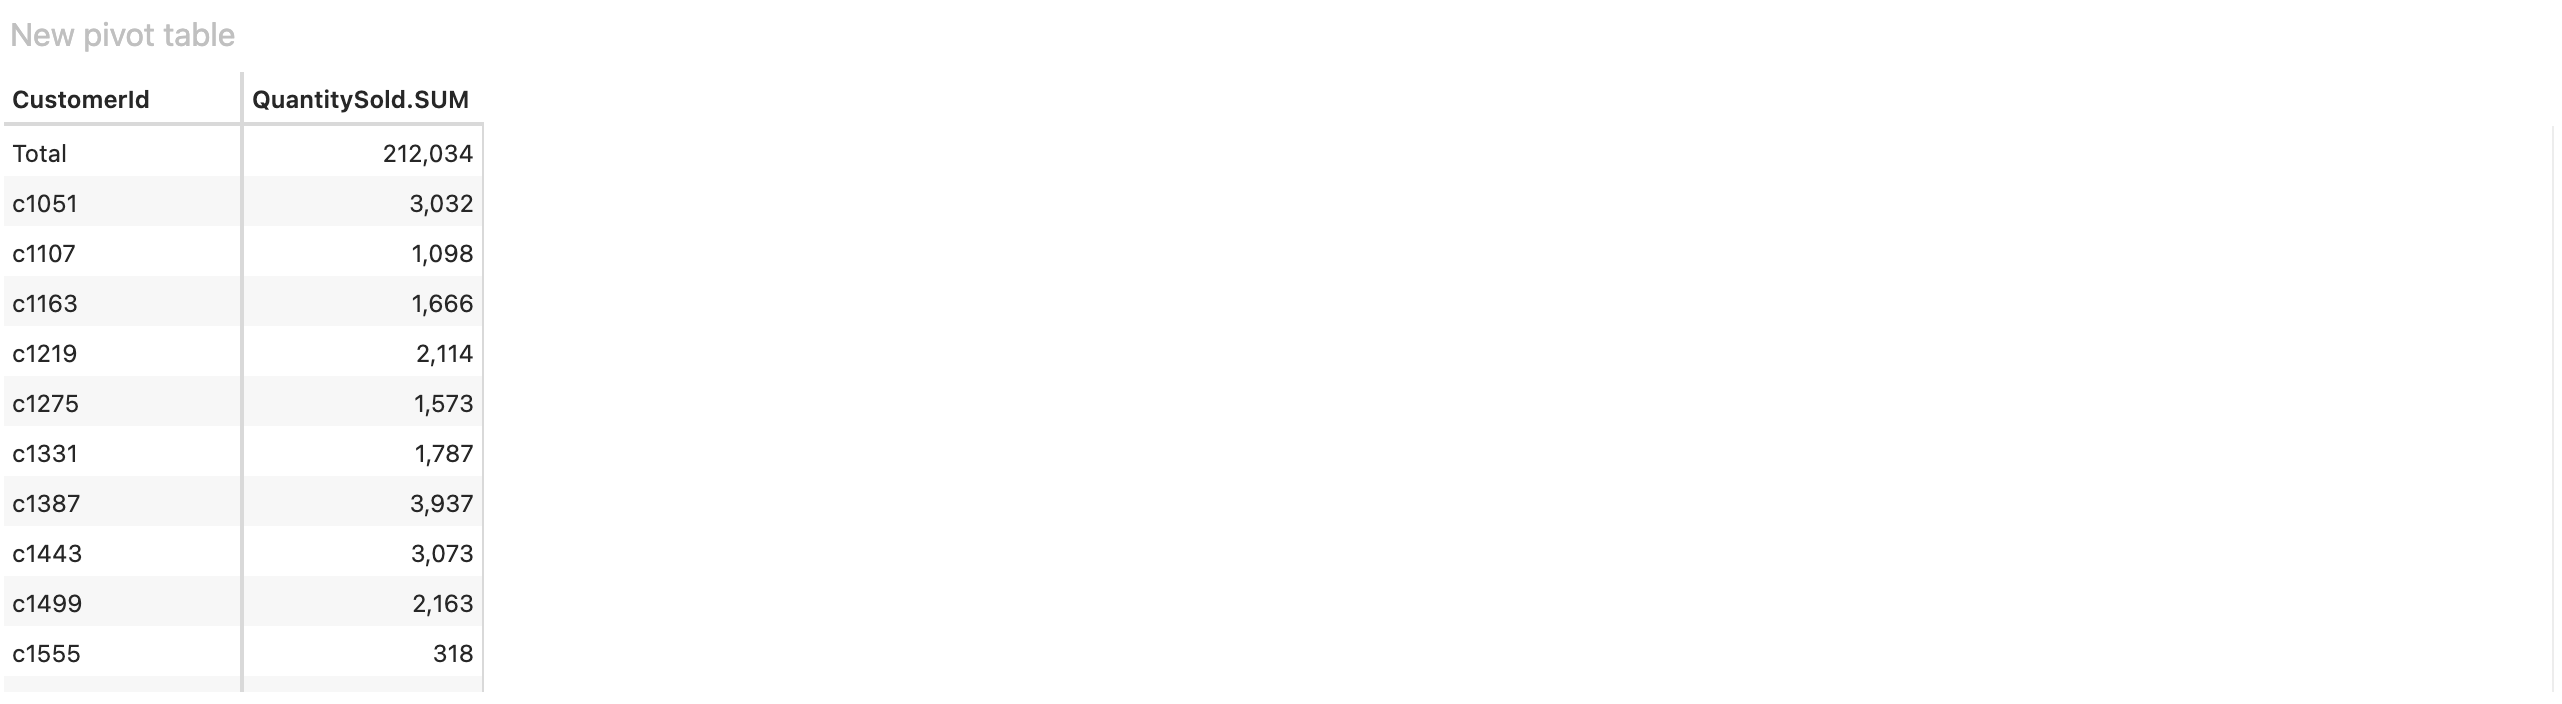

In [13]:
session.widget

However if we set the `visible` property of the `CustomerId` hierarchy to `False`, it will hide it from our list of available hierarchies as expected. 

💡 **Note:** Notice that the total number of hierarchies in the data model (`23`) does not change whether or not the `visible` property for a hierarchy is set to `True` or `False`, and that the previous `session.widget` still shows the analysis for quantity sold per customer, as the hierarchy is not **deleted** but **hidden**.

In [14]:
h["CustomerId"].visible = False

<img src="https://data.atoti.io/notebooks/hierarchies/images/hierarchies-visible-false.png" alt="hierarchies-visible-false" width="225"/>

### Using multi-level hierarchies

When a parent-child relationship exists among multiple single-level hierarchies, we may want to logically group these single-level hierarchies together as a multi-level hierarchy for enhanced granularity on drill-down analytics or when calculating aggregations at a specific level.

For example, let's create a multi-level `Geography` hierarchy. 

In [15]:
h["Geography"] = [l["Region"], l["Country"]]
h["Geography"]

Here, we can see that the shallowest level of our multi-level `Geography` hierarchy is our `Region` level, and our deepest level is our `Country` level. This makes sense as countries fall within the umbrella of overarching geographical regions.

To better illustrate this, let's do some quick analysis with our new multi-level `Geography` hierarchy. Here we can see the breakdown of `QuantitySold.SUM` at every level: `Region` and `Country`, and specifically we are viewing the breakdown for quantity of products sold to customers based in the `Latin America` and `Northern America` regions along with their underlying countries for each region.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
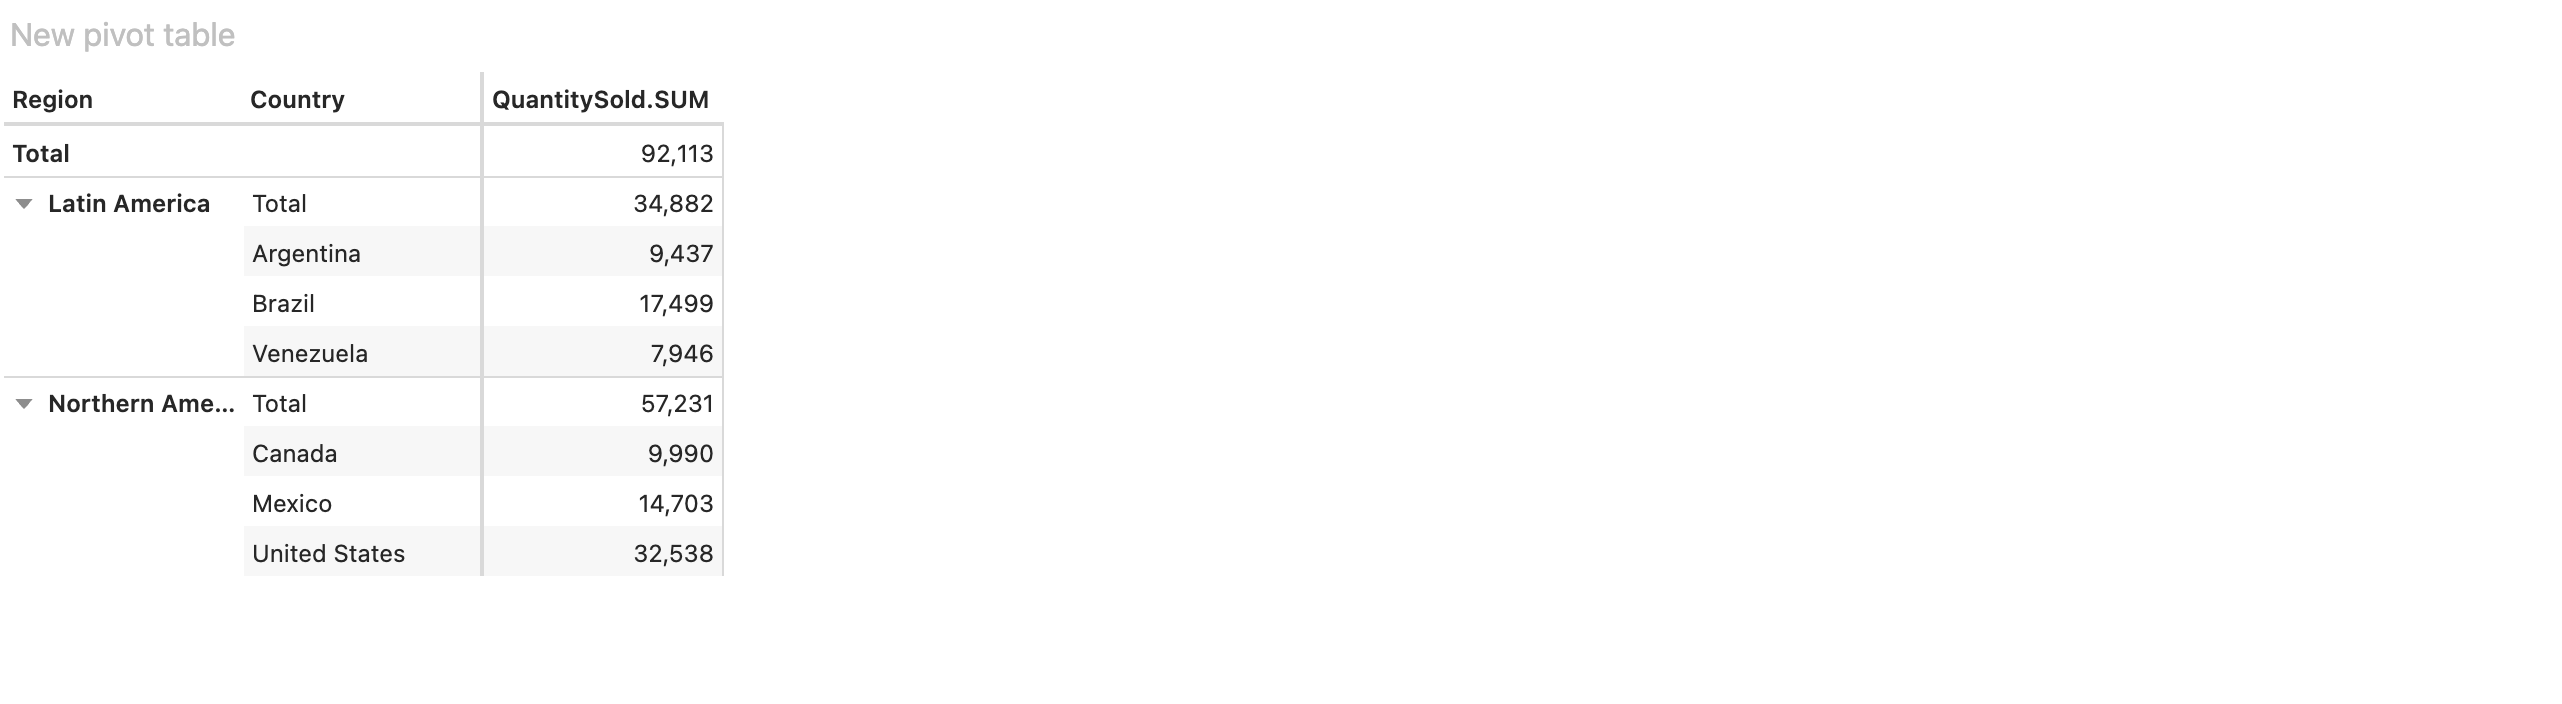

In [16]:
session.widget

However, let's get more specific. Imagine we only wanted the total quantity of products sold to customers in both the entirety of the `Latin America` region in addition to only the more specific country of `United States`.

To do this, we can use the [isin()](https://docs.atoti.io/latest/api/atoti.Hierarchy.isin.html#atoti.Hierarchy.isin) hierarchy function in conjunction with the general [filter](https://docs.atoti.io/latest/api/atoti.filter.html#atoti.filter) function to traverse the variability of shallow to deep levels within a multi-level hierarchy. This looks something like the following:

In [17]:
m["QuantitySold.SUM in Latin America and United States"] = tt.filter(
    m["QuantitySold.SUM"],
    h["Geography"].isin(("Latin America",), ("Northern America", "United States")),
)

Now when we take a look at the values of our new measure, we only see the aggregations for the hierarchy levels specified.

💡 **Note:** We've included our original `QuantitySold.SUM` measure in our analysis as a side-by-side comparison to better illustrate this difference.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
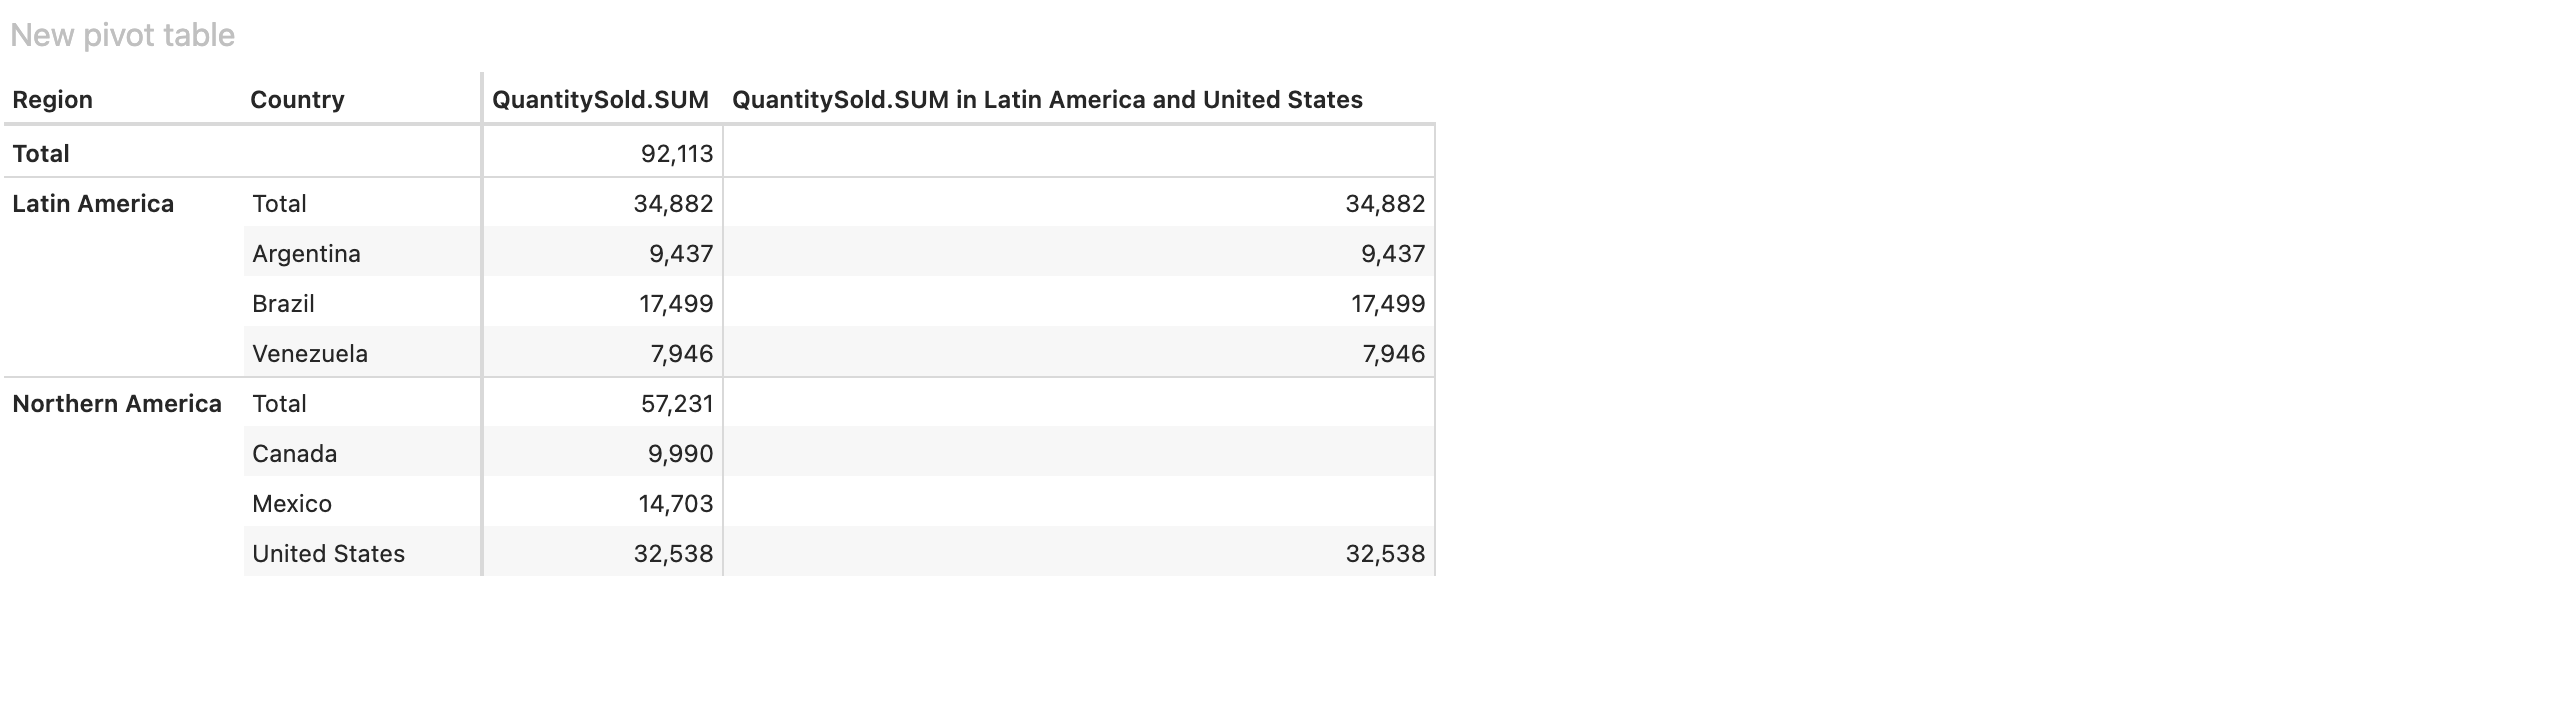

In [18]:
session.widget

### Using slicing hierarchies

Slicing hierarchies are used when we want a hierarchy that is no longer aggregable at the top level/across all of its underlying members. For example, within our data model imagine that for every order made, a corresponding record of inventory with an `AsOfDate` is taken for each product sold. We can assume that each product started at `10,000` items in inventory. In this case, it would not provide any meaningful information to aggregate the current state or quantity of inventory across all the `AsOfDate` member dates, nor would it be a good use of computational resources.

Let's see how this works in practice.

In [19]:
inventory = session.tables["Inventory"]
inventory.head()

,AsOfDate,Inventory
InventoryId,,
6,2024-02-15,9298
20,2024-02-15,9323
34,2024-02-15,8635
48,2024-02-15,9620
62,2024-02-15,8944


Here, we've already loaded the above `Inventory` table into our data model. Let's re-arrange how this looks by `AsOfDate` first and create the `Inventory.SUM` measure, as we need to explicitly create new measures for joined tables and their numeric columns.

We now have the following, and for simplicity let's focus on `ProductId` `1072`.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
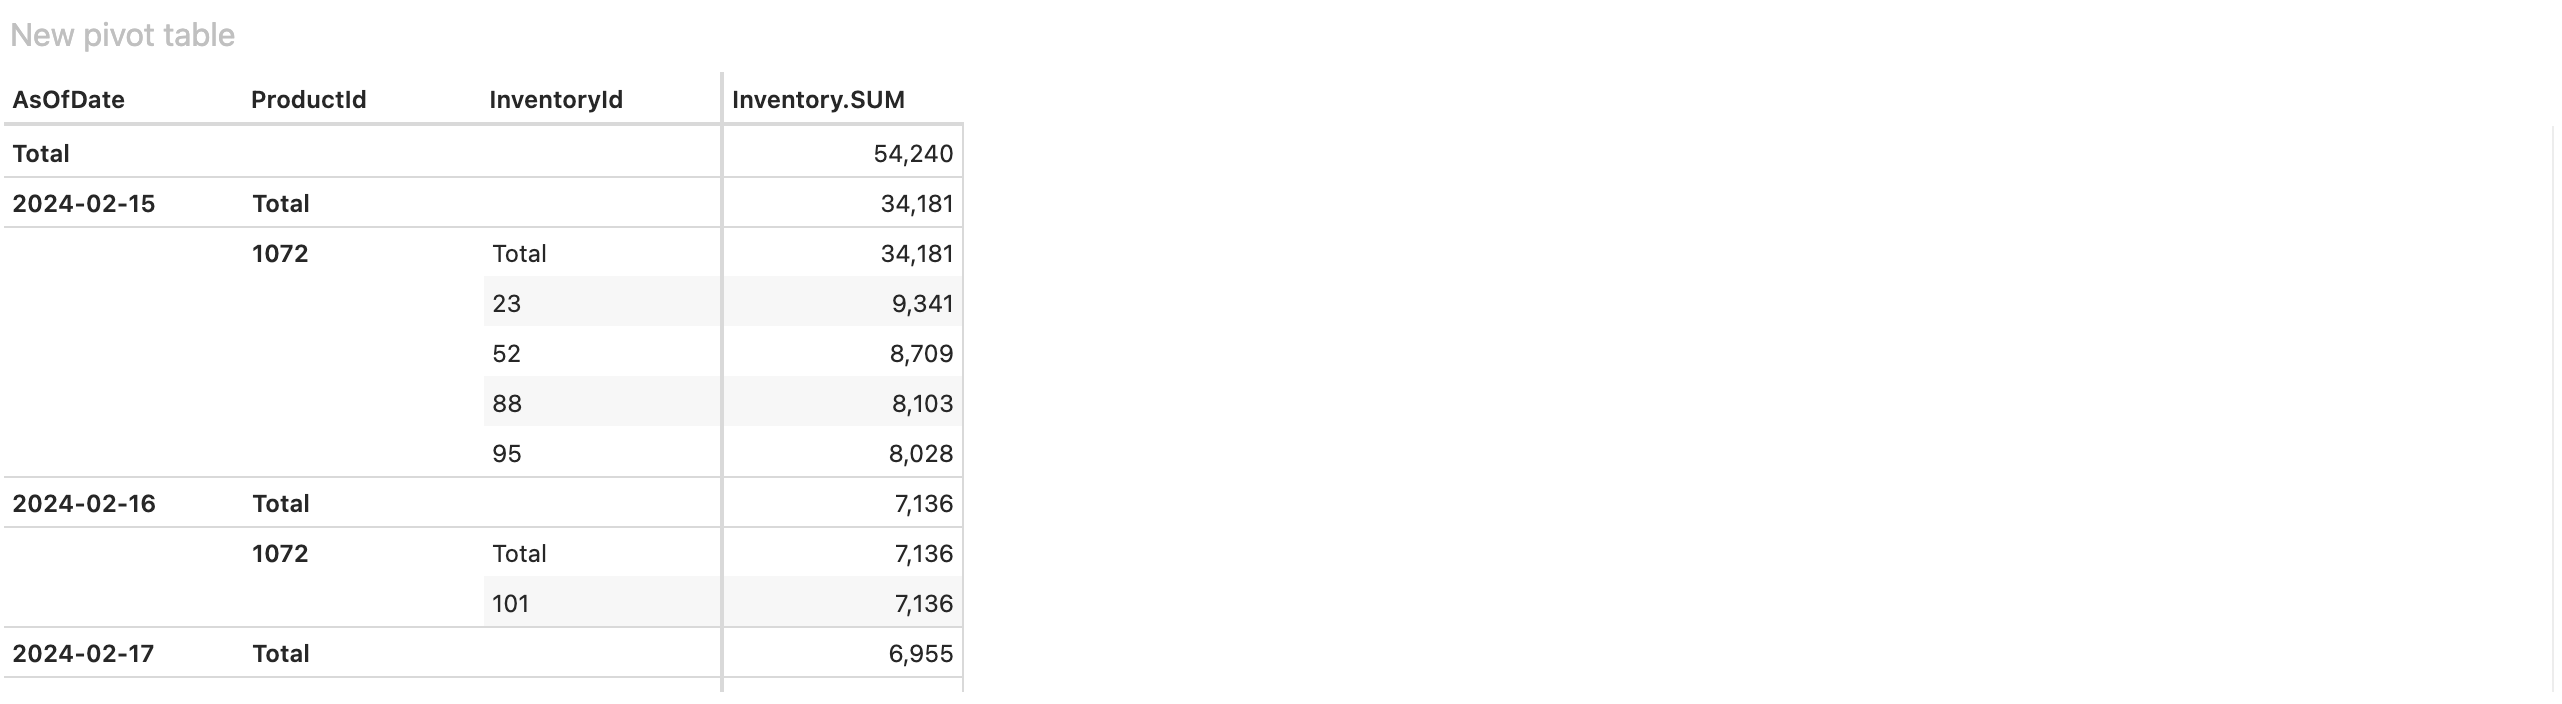

In [20]:
m["Inventory.SUM"] = tt.agg.sum(session.tables["Inventory"]["Inventory"])
session.widget

Notice that there is a grand total of `54,240` for all of the `AsOfDate` members: `2024-02-15`, `2024-02-16`, `2024-02-17`,`2024-02-18`. Since it doesn't make sense to aggregate an inventory amount across dates, let's prevent the `AsOfDate` hierarchy from being aggregable across all of its members.

💡 **Note:** We create a new slicing hierarchy `AsOfDateSlicing` from `AsOfDate` so that we do not break the above widget for `AsOfDate` and can show a comparison. 

In [21]:
h["AsOfDateSlicing"] = [l["AsOfDate"]]
h["AsOfDateSlicing"].slicing = True

And we can confirm that `AsOfDateSlicing` is indeed a slicing hierarchy by calling the same `slicing` property.

In [22]:
h["AsOfDateSlicing"].slicing

True

Now, when we pull up our data once more, notice the grand total of `54,240` for all of the `AsOfDate` members is no longer calculated.

💡 **Note:** If we right-click within the Atoti JupyterLab widget, the option for `Totals` > `Show grand total rows` also disappears for slicing hierarchies.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
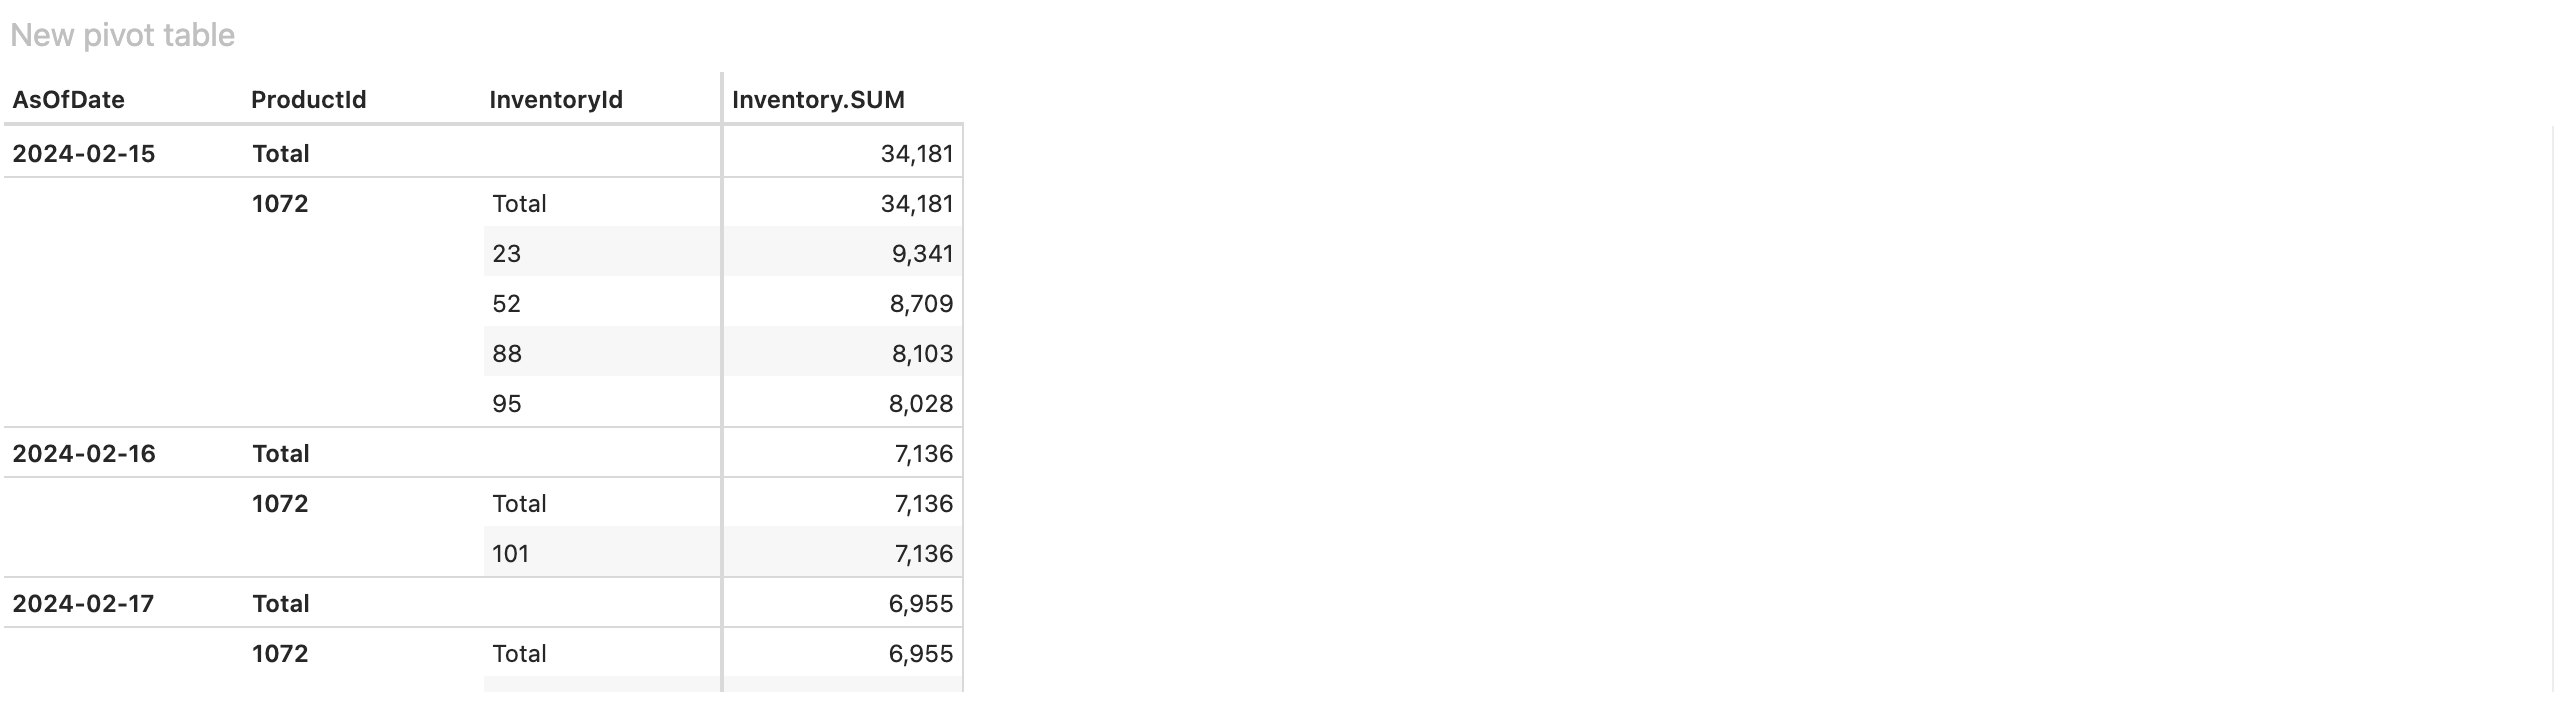

In [23]:
session.widget

Great, this now makes more sense and saves us some computation! But it seems like we're still erroneously aggregating our inventory amounts at the `ProductId` level, where we see a total of `34,181` for `ProductId` `1072` on `2024-02-15`. To fix this further, we'll need to briefly talk about the [single_value](https://docs.atoti.io/latest/api/atoti.agg.single_value.html#atoti.agg.single_value) aggregation function, which performs aggregations at a specified scope or level.

For example, we can create a `Inventory.SV` measure at the granularity of every `Inventory` record, and a corresponding `QuantitySold.SV` measure at the granularity of every `Orders` record.

In [24]:
m["Inventory.SV"] = tt.agg.single_value(session.tables["Inventory"]["Inventory"])
m["QuantitySold.SV"] = tt.agg.single_value(session.tables["Orders"]["QuantitySold"])

This now looks like the following:

💡 **Note:** You may have noticed that we have `Totals` appear in our pivot table despite us calculating single value measures at the lowest granularity of our `Inventory` and `Orders` records. This is because the [single_value](https://docs.atoti.io/latest/api/atoti.agg.single_value.html#atoti.agg.single_value) function considers that "*if the value is the same for all members of the level the operand is being aggregated on, it will be propagated to the next level.*"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
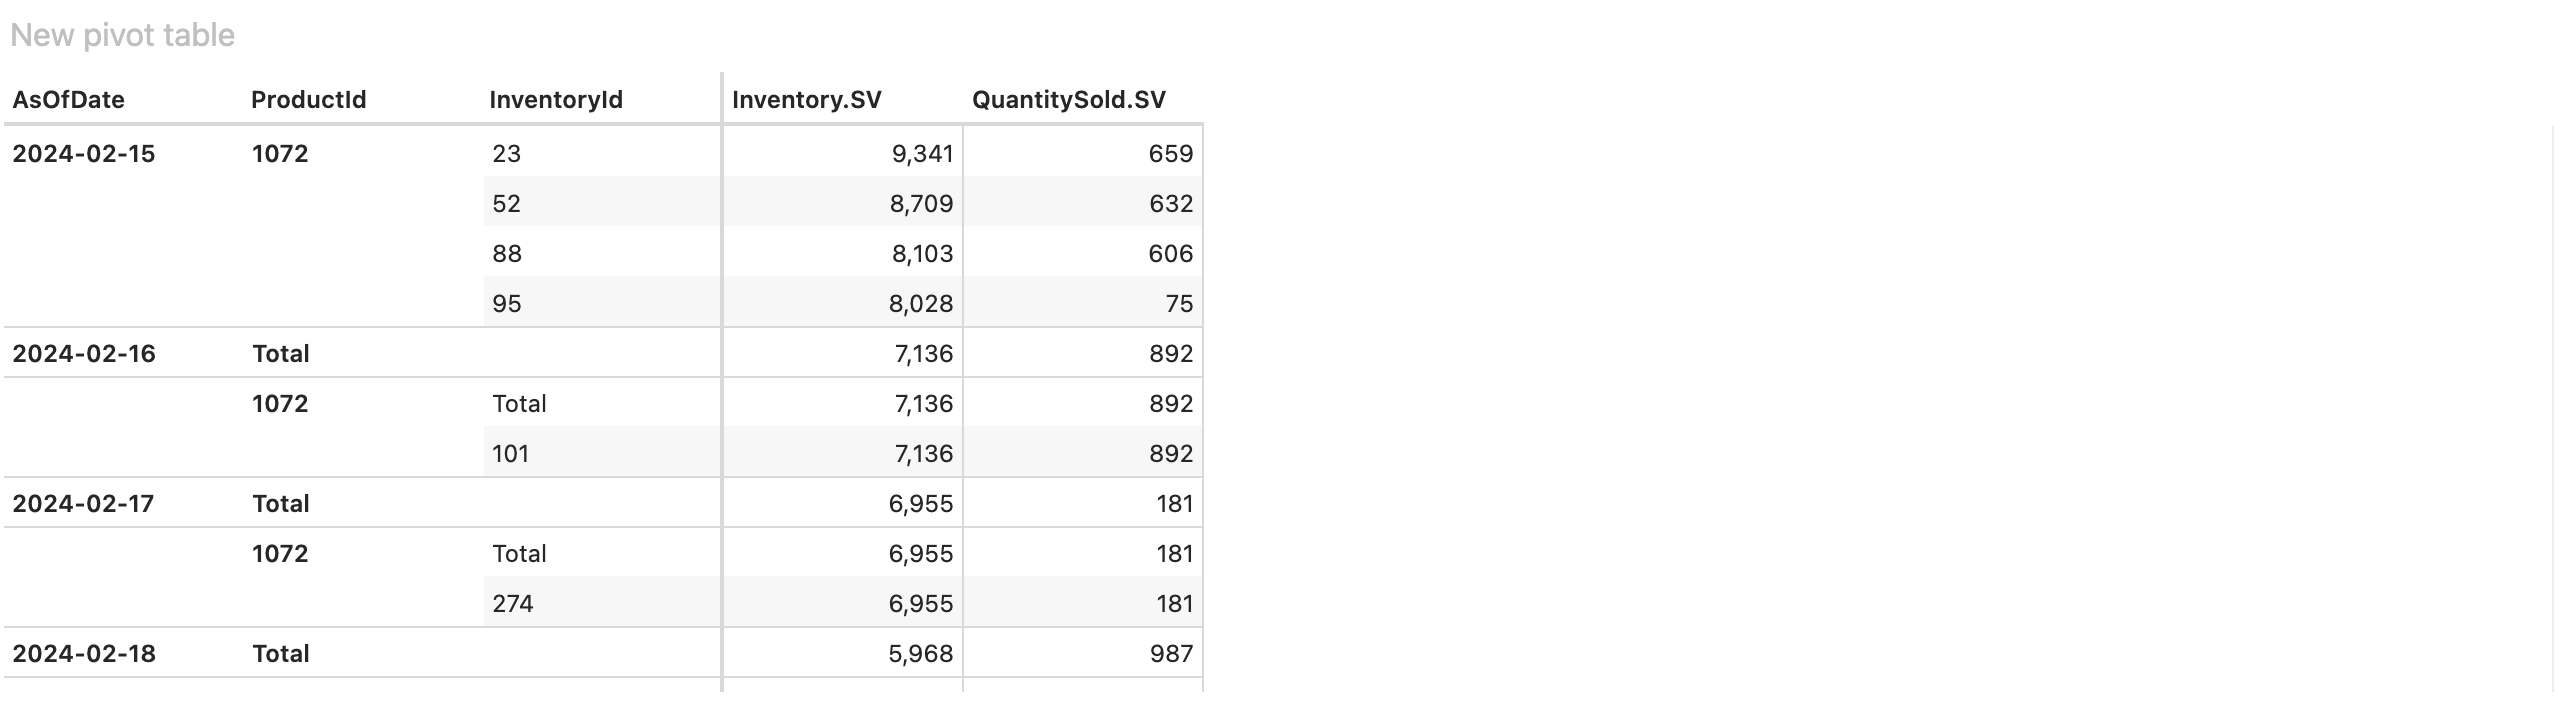

In [25]:
session.widget

Finally, let's add some finishing touches for the widget by right-clicking and disabling the option for `Totals` > `Show all totals` to give our table a cleaner look.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
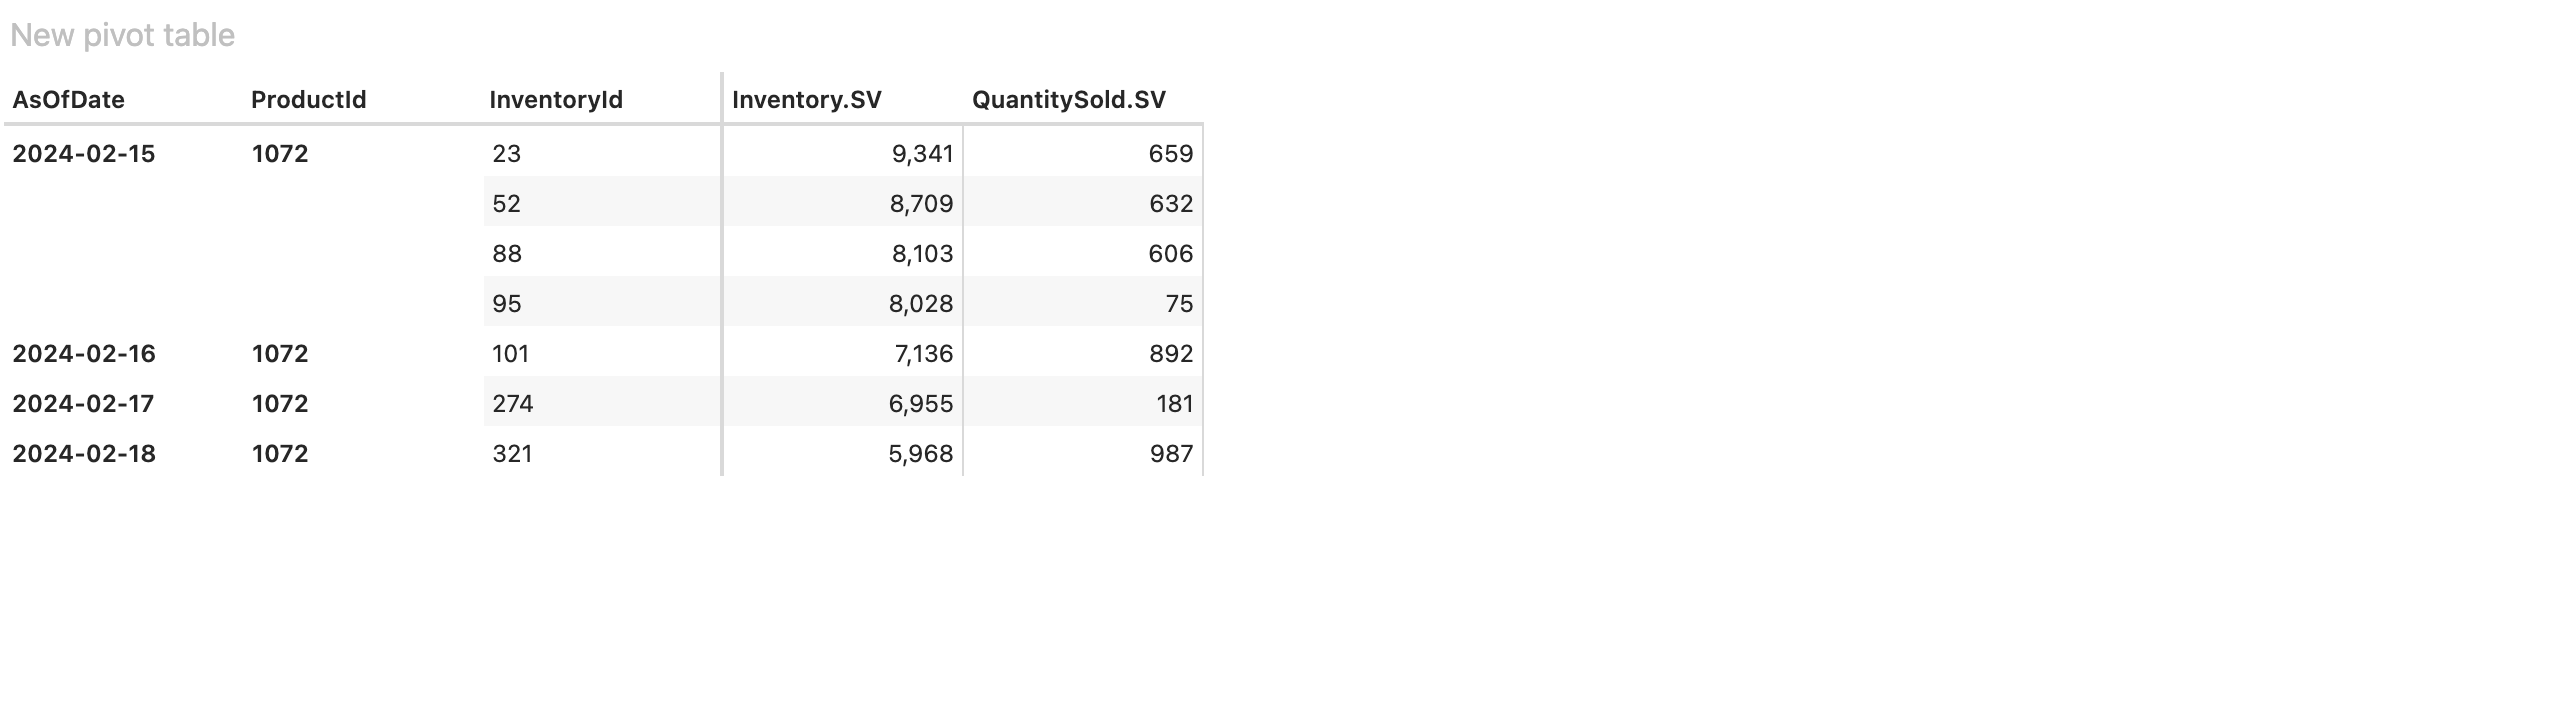

In [26]:
session.widget

#### Using virtual hierarchies

A virtual hierarchy is a lightweight hierarchy implemented in Atoti that offers a smaller memory footprint by not storing its members in the cube. This helps optimize/save resources when dealing with hierarchies that have high cardinality or many possible distinct values. Usually, these are identifiers such as User ID, Shopping Cart ID, or Trade ID, where the hierarchy can have thousands of distinct values.

The [virtual](https://docs.atoti.io/latest/api/atoti.Hierarchy.virtual.html) hierarchy property, which when assigned either `True` or `False`, determines whether the hierarchy is a virtual hierachy or not, respectively.

💡 **Note:** Virtual hierarchies come at the cost of trade-offs, see the [virtual hierarchies](../virtual-hierarchies/main.ipynb) notebook to delve deeper into the pros and cons of using virtual hierarchies.

Let's take a look at a hierarchy that has a high amount of cardinality within our data model, such as the `OrderId` hierarchy.

In [27]:
orders_table = session.tables["Orders"]
m["Distinct OrderId"] = tt.agg.count_distinct(orders_table["OrderId"])

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
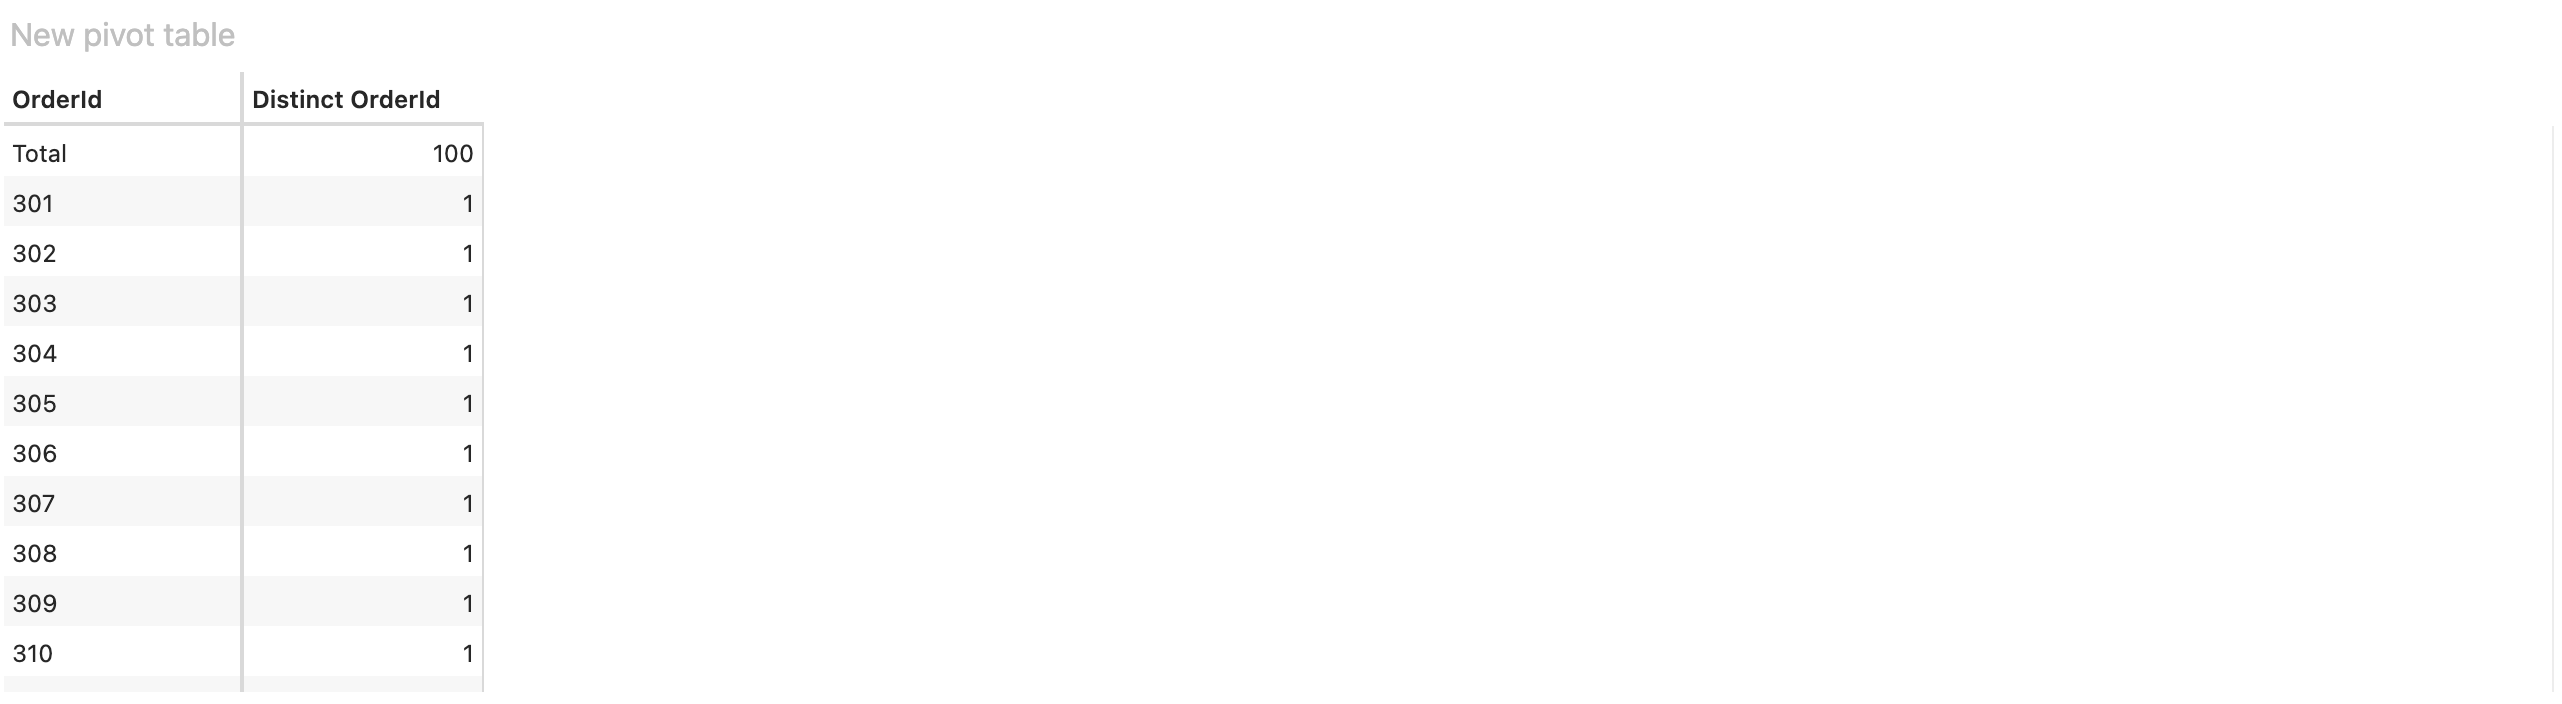

In [28]:
session.widget

Here we see that we have `400` members for the `OrderId` hierarchy. When we check if the `OrderId` hierarchy is a virtual hierarchy, it shows as `False`.

In [29]:
h["OrderId"].virtual

False

Let's set the `OrderId` hierarchy as a virtual hierarchy by setting its `virtual` property to `True`.

In [30]:
h["OrderId"].virtual = True

Now, let's take a look at our Atoti Server logs to see the improved memory footprint that we're now using for the cube.

💡 **Note**: Not sure the difference between heap and direct memory? Take a look at this [explanation](https://stackoverflow.com/questions/30622818/what-is-the-difference-between-off-heap-native-heap-direct-memory-and-native-m).

In [31]:
session.logs_path

PosixPath('/Users/aya/.atoti/1732649740_855082/logs/server.log')

![server-logs](https://data.atoti.io/notebooks/hierarchies/images/server-logs.png)



**💡 Note**: The underlying JVM for the Atoti Server will automatically trigger a garbage collection (GC) when it approaches the maximum memory capacity it has been allocated. To see the effects of your virtual hierarchies in regards to decreasing memory footprint *before* GC automatically executes, you may have to manually invoke GC like so:

```bash
(atoti) aya@aya atoti % jcmd             
53319 jdk.jcmd/sun.tools.jcmd.JCmd
759 com.intellij.idea.Main
53085 /Users/aya/Library/Caches/pypoetry/virtualenvs/notebooks-k2yxt2gM-py3.10/lib/python3.10/site-packages/atoti/data/atoti.jar --bind-address=127.0.0.1 --enable-auth

(atoti) aya@aya atoti % jcmd 53085 GC.run
53085:
Command executed successfully
```

And that's it! Great job, this concludes our next lesson with hierarchies in Atoti! 🎉

We hope that this walk through gives you a further jump start for working with hierarchies in Atoti 😊. Stay tuned for more advanced topics on Atoti hierarchies in the future! Until then, take care! 👋

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=hierarchy-manipulations" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>